In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [2]:
input_fname = 'test_toymodel.in'

nTurn = 32768
nTurnSplit = 0

nCore_y = 8
nCore_z = 6

NL_t = 0.4
NL_c = 0.01
dTune = 0.04

fID = 32768*2

# 1. Preparation

### 1.1 read InputFile and simplify lattice

In [3]:
beam, lattice = impact.readInputFile(input_fname);
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0
lattice[0].turns = 2*nTurn
betx = beam.distribution.betx
alfx = beam.distribution.alfx

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [5]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
lattice[1].n_sckick = 100
lattice[1].strength_t = NL_t
lattice[1].pipe_radius = 0.02*np.sqrt(2)
lattice[2].tune_advance = dTune

### 1.2. generate particles

In [6]:
testP = 0.0
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
nx = 100
xmax = 0.98
for x in np.linspace(-xmax,xmax,nx):
    for y in np.linspace(-xmax,xmax,nx):
        if x**2+y**2<=xmax**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k]) 
pTest = np.array(pTest)
npt = len(pTest)
beam.n_particles = npt
print('initial npt=',npt)

initial npt= 7668


In [7]:
unnormalize(pTest)
impact.writeParticleData(pTest, ke, mass, freq)

# 2. FMA

### 2.1. run

In [8]:
TBT = impact.getElem('TBT')
TBT.file_id = fID
lattice.insert(1,TBT)

impact.writeInputFile(beam,lattice) 
impact.run(beam)

0

In [9]:
indexTBT,TBTdata = impact.readTBT(fID,ke,mass,freq)
TBTdata = TBTdata[:,:4,:]
npt = len(indexTBT)

In [10]:
X = (TBTdata[:,0,:] - 1j*(betx*TBTdata[:,1,:]+alfx*TBTdata[:,0,:]))/(NL_c*np.sqrt(betx))
Y = (TBTdata[:,2,:] - 1j*(betx*TBTdata[:,3,:]+alfx*TBTdata[:,2,:]))/(NL_c*np.sqrt(betx))
TBTdata = None

tuneXbefore= np.zeros([1,npt])
tuneXafter = np.zeros([3,npt])
tuneYbefore= np.zeros([1,npt])
tuneYafter = np.zeros([3,npt])
for i in range(npt):
    tuneXbefore[:,i],amp,dummy = impact.util.naff(1,X[:nTurn,i]-np.mean(X[:nTurn,i]),window_id=1)
    tuneXafter [:,i],amp,dummy = impact.util.naff(3,X[nTurn:,i]-np.mean(X[nTurn:,i]),window_id=1)
    tuneYbefore[:,i],amp,dummy = impact.util.naff(1,Y[:nTurn,i]-np.mean(Y[:nTurn,i]),window_id=1)
    tuneYafter [:,i],amp,dummy = impact.util.naff(3,Y[nTurn:,i]-np.mean(Y[nTurn:,i]),window_id=1)

### Apply NAFF

In [11]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [12]:
Xdiff = np.zeros(npt)
Ydiff = np.zeros(npt)
for i in range(npt):
    Xdiff[i] = getClosestDiff(tuneXbefore[:,i],tuneXafter[:,i])
    Ydiff[i] = getClosestDiff(tuneYbefore[:,i],tuneYafter[:,i])
Adiff = np.sqrt(Xdiff**2 +Ydiff**2)

Adiff = np.log10(Adiff+1.0e-6)
Xdiff = np.log10(Xdiff+1.0e-6)
Ydiff = np.log10(Ydiff+1.0e-6)

iMaxX = np.argmax(Xdiff)
iMaxY = np.argmax(Ydiff)
iMaxA = np.argmax(Adiff)
iMinX = np.argmin(Xdiff)
iMinY = np.argmin(Ydiff)
iMinA = np.argmin(Adiff)

### 2.2 plot

##### FFT

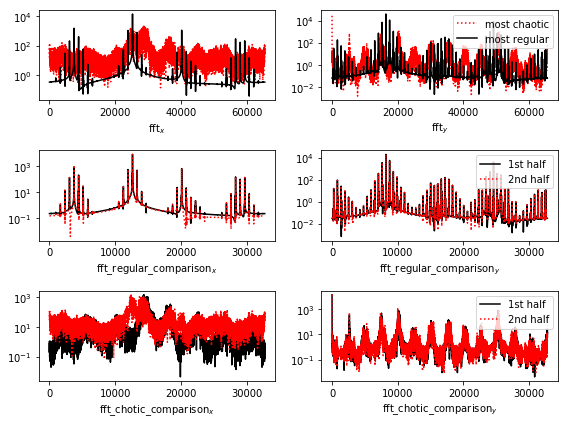

In [13]:
plt.figure(figsize=[8,6])
plt.subplot(3,2,1)
plt.semilogy(np.abs(np.fft.fft(X[:,iMaxX])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[:,iMinX])),'k')
plt.xlabel('fft$_x$')
plt.subplot(3,2,2)
plt.semilogy(np.abs(np.fft.fft(Y[:,iMaxY])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[:,iMinY])),'k')
plt.legend(['most chaotic','most regular'],loc=1)
plt.xlabel('fft$_y$')
plt.subplot(3,2,3)
plt.semilogy(np.abs(np.fft.fft(X[:nTurn,iMinX])),'k')
plt.semilogy(np.abs(np.fft.fft(X[nTurn+nTurnSplit:,iMinX])),'r:')
plt.xlabel('fft_regular_comparison$_x$')
plt.subplot(3,2,4)
plt.semilogy(np.abs(np.fft.fft(Y[:nTurn,iMinY])),'k')
plt.semilogy(np.abs(np.fft.fft(Y[nTurn+nTurnSplit:,iMinY])),'r:')
plt.xlabel('fft_regular_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.subplot(3,2,5)
plt.semilogy(np.abs(np.fft.fft(X[:nTurn,iMaxX])),'k')
plt.semilogy(np.abs(np.fft.fft(X[nTurn+nTurnSplit:,iMaxX])),'r:')
plt.xlabel('fft_chotic_comparison$_x$')
plt.subplot(3,2,6)
plt.semilogy(np.abs(np.fft.fft(Y[:nTurn,iMaxY])),'k')
plt.semilogy(np.abs(np.fft.fft(Y[nTurn+nTurnSplit:,iMaxY])),'r:')
plt.xlabel('fft_chotic_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.tight_layout()
plt.savefig('FMA.FFT.mu='+str(dTune)+'.turn='+str(fID)+'.png',dpi=180)
# plt.close()


##### Tune plot

In [14]:
def resonnace(ix,iy,N):
    if ix==0 and iy==0:
        nux=0
        nuy=0
    else:
        if ix==0:
            nux = np.linspace(-1,1,2)
            nuy = np.linspace(float( N )/iy, float( N )/iy, 2)
        elif iy==0:
            nuy = np.linspace(-1,1,2)
            nux = np.linspace(float( N )/ix, float( N )/ix, 2)
        else:        
            nux = np.linspace(-1,1,2)
            nuy = ix/float(iy)*nux +  N/float(iy)
    return nux,nuy

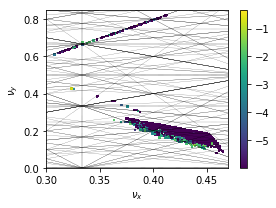

In [21]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.2,ls='--')
f1=plt.scatter(tuneXbefore[0,:],tuneYbefore[0,:],c=Adiff,s=2.0,marker='s')
    
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(0.3,0.47)
plt.ylim(0.0,0.85)
plt.tight_layout()
plt.savefig('FMA.tune.mu='+str(dTune)+'.turn='+str(fID)+'.png',dpi=180)
# plt.close()

##### DA

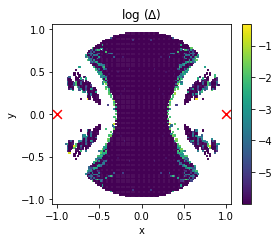

In [16]:
xmax = np.max([np.real(X[0,:]),np.real(Y[0,:])])
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),c=Adiff,s=1.6,marker='s')
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'log ($\Delta$)')
plt.colorbar(f1)
plt.savefig('FMA.DA.mu='+str(dTune)+'.turn='+str(fID)+'.png',dpi=180)